In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from TNN import Mining, Model
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

In [2]:
device = torch.device('cpu') #cuda:0
tsne = TSNE(random_state=0)
batch_size_train = 256

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.datasets import EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

from TNN import Mining, Model
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

In [4]:
train_loader = DataLoader(EMNIST('./EMNIST/', train=True, download=True,split = 'letters',
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(EMNIST('./EMNIST/', train=False, download=True, split = 'letters',
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)

In [5]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

In [6]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Thiru\Anaconda3\envs\siamese\lib\site-packages\numpy\core\_

IS IT EVEN WORKING WTF
(27, 3)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


IS IT EVEN WORKING WTF
(27, 3)


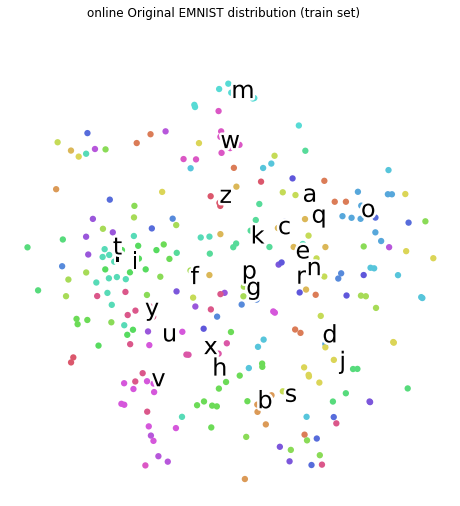

posx and posy should be finite values
posx and posy should be finite values


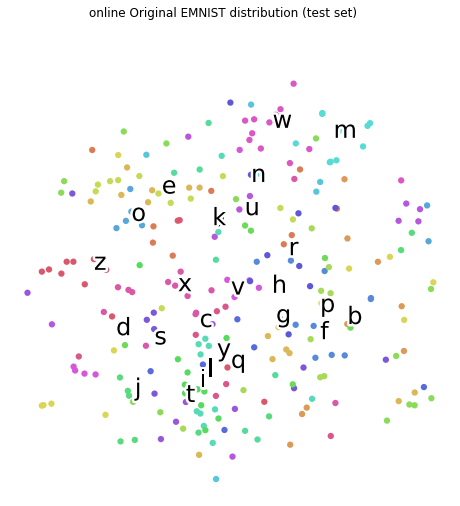

In [7]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online Original EMNIST distribution (train set)', dataset='EMNIST')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online Original EMNIST distribution (test set)', dataset='EMNIST')

In [8]:
model = Model.TNN(input_shape=x_train.shape[1:])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
margin=0.4
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss, pos_triplet, valid_triplet = Mining.online_mine_all(labels, outputs, margin=margin, squared=True, device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2 == 0:
            print(f"At epoches = {epoch}, i = {i}, loss = {loss:.5f}, trainable_triplet = {pos_triplet}, total_triplets = {valid_triplet}"
                  , end='\r')
    epoch_loss = running_loss / len(train_loader)
    if epoch%10 == 0:
        torch.save(net.state_dict(), 'triplet_loss_emnist'+epoch+'.pt')

    
    print(" "*100)
    print(f"At epoches = {epoch}, epoch_loss = {epoch_loss}")
print('Finished Training')

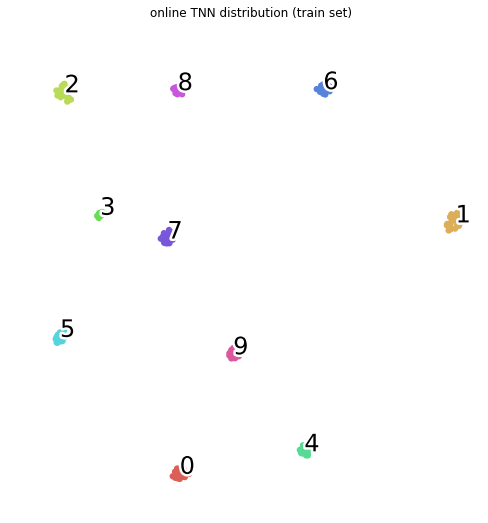

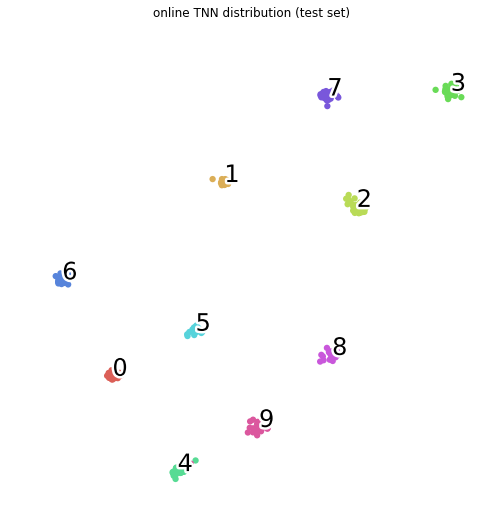

In [9]:
train_outputs = model(x_train)
test_outputs = model(x_test)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online TNN distribution (train set)', dataset= 'EMNIST')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online TNN distribution (test set)', dataset='EMNIST')